# London AirBnB Data

In [1]:
from typing import Tuple
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [2]:
import sys

sys.path.append('..')

In [3]:
plt.style.use("airbnb.mplstyle")

## Business understanding

We know that the Coronavirus-19 virus has affected the travel industry a lot. In this 
piece of analysis we try to understand the impact on volume, availability and sentiment of 
airbnb guests.

## Load data

In [4]:
!ls 

airbnb-london-eda.ipynb  airbnb.mplstyle


In [5]:
class AirbnbConfig:
    data_dir: str = os.path.join(f"..{os.path.sep}" "data")
    calendar_file: str = "calendar.csv"
    listings_file: str = "listings.csv"
    reviews_file: str = "reviews.csv"

In [6]:
def load_dataets(year_dir: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Loads calendar, listings and reviews dataset for given date directory. 
    
    Parameters:
    year_dict (str): Directory to find raw files. 
    
    Returns:
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: calendar, listings, and reviews dataframes respectively. 
    
    """
    path = os.path.join(AirbnbConfig.data_dir, year_dir)
    calendar = pd.read_csv(os.path.join(path, AirbnbConfig.calendar_file), parse_dates=["date"], thousands=',')
    listings = pd.read_csv(os.path.join(path, AirbnbConfig.listings_file))
    reviews = pd.read_csv(os.path.join(path, AirbnbConfig.reviews_file), parse_dates=["date"])

    return calendar, listings, reviews

Let's load the data from both 2020 and 2019, using the prefix 'a_' to denote 2020 or 'after' and 'b_' is 2019 or 'before'.

In [7]:
a_calendar, a_listings, a_reviews = load_dataets("2020")

In [8]:
b_calendar, b_listings, b_reviews = load_dataets("2019")

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Data understanding

## Calendar QA

In [28]:
a_calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,208952,2020-08-26,f,$263.00,$263.00,2.0,30.0
1,81951,2020-08-27,f,$190.00,$190.00,5.0,10.0
2,81951,2020-08-28,t,$190.00,$190.00,5.0,10.0


In [29]:
b_calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2019-08-10,t,$50.00,$50.00,1.0,29.0
1,158939,2019-08-10,f,$110.00,$110.00,2.0,14.0
2,158939,2019-08-11,f,$110.00,$110.00,2.0,14.0


* only select where listing is available

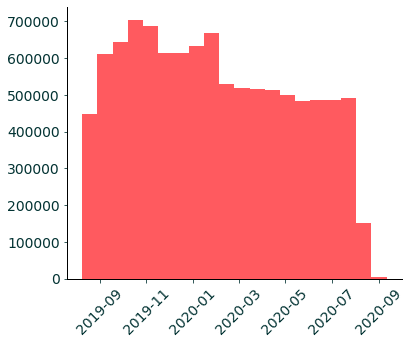

In [10]:
b_calendar.loc[b_calendar["available"] == "t", :].date.hist(bins=20)
plt.xticks(rotation=45);

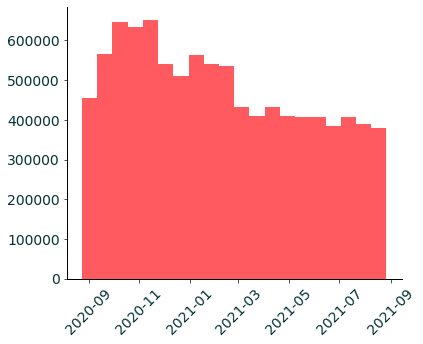

In [11]:
a_calendar.loc[a_calendar["available"] == "t", :].date.hist(bins=20)
plt.xticks(rotation=45);

In [12]:
old_avail = b_calendar.loc[b_calendar["available"] == "t", :]
new_avail = a_calendar.loc[a_calendar["available"] == "t", :]

In [13]:
old_avail['date_month'] = old_avail['date'].dt.strftime('%d/%m')
new_avail['date_month'] = new_avail['date'].dt.strftime('%d/%m')

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


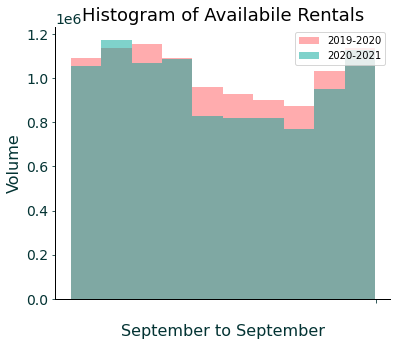

In [14]:
x = old_avail.date_month
y = new_avail.date_month

bins=10

plt.hist(x, bins=bins, alpha=0.5, label='2019-2020')
plt.hist(y, bins=bins, alpha=0.5, label='2020-2021')

plt.legend(loc='upper right')
plt.xticks(ticks=["1"], labels=[" "])
plt.xlabel("September to September")
plt.ylabel("Volume")
plt.title("Histogram of Availabile Rentals")

plt.show()

## Prepare Data

* strip out the "$" sign from the price column

In [9]:
def clean_calendar(calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Converts string values to numberic, strips $ sign and replaces NaN values with 0. We replace NaN values with 0 so 
    that the whole price column is numberic, and as invalid properties should not have a price assiciated with them. 
    
    Parameters:
    calendar (pd.DataFrame): Raw calendar datafrane
    
    Returns:
    pd.DataFrame: cleaned dataframe 
    
    """

    calendar.fillna({"price": "$0"}, inplace=True)
    calendar["currency"] = calendar["price"].astype("str").str[0]
    calendar["price"] = calendar["price"].str.replace(",", "").str[1:].astype(float)
    
    calendar = calendar.loc[calendar["available"] == "t", :]
    return calendar

In [10]:
calendar = a_calendar

In [11]:
calendar.fillna({"price": "$0"}, inplace=True)

In [12]:
a_calendar = clean_calendar(a_calendar)

In [13]:
b_calendar = clean_calendar(b_calendar)

## Listings QA

In [14]:
a_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20200824024753,2020-08-26,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,...,10.0,9.0,9.0,NaN,t,2,2,0,0,1.51
1,13913,https://www.airbnb.com/rooms/13913,20200824024753,2020-08-27,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/ffb507b7-983c...,54730,https://www.airbnb.com/users/show/54730,...,10.0,9.0,9.0,NaN,f,3,1,2,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20200824024753,2020-08-26,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.68


## How has the market changed?

Let's take a look at the same period in 2020 vs 2019

In [15]:
a_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20200824024753,2020-08-26,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,...,10.0,9.0,9.0,NaN,t,2,2,0,0,1.51
1,13913,https://www.airbnb.com/rooms/13913,20200824024753,2020-08-27,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/ffb507b7-983c...,54730,https://www.airbnb.com/users/show/54730,...,10.0,9.0,9.0,NaN,f,3,1,2,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20200824024753,2020-08-26,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.68
3,17402,https://www.airbnb.com/rooms/17402,20200824024753,2020-08-27,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,...,9.0,10.0,9.0,NaN,t,14,14,0,0,0.37
4,17506,https://www.airbnb.com/rooms/17506,20200824024753,2020-08-26,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,https://a0.muscache.com/pictures/11901327/e63d...,67915,https://www.airbnb.com/users/show/67915,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN


<AxesSubplot:>

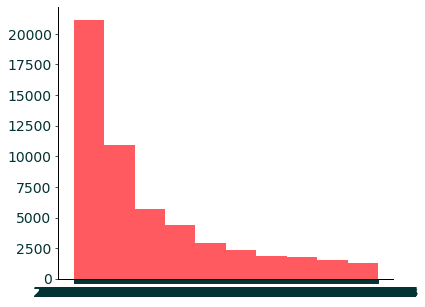

In [16]:
a_listings.last_review.hist()

<AxesSubplot:>

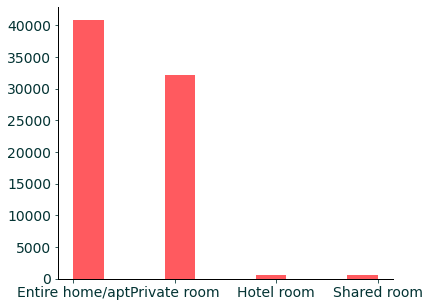

In [17]:
a_listings.room_type.hist()

<AxesSubplot:>

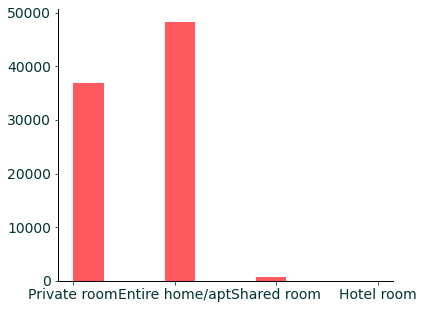

In [18]:
b_listings.room_type.hist()

In [19]:
a_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,currency
2,81951,2020-08-28,t,190.0,$190.00,5.0,10.0,$
3,81951,2020-08-29,t,190.0,$190.00,5.0,10.0,$
4,81951,2020-08-30,t,190.0,$190.00,5.0,10.0,$
5,81951,2020-08-31,t,190.0,$190.00,5.0,10.0,$
6,81951,2020-09-01,t,190.0,$190.00,5.0,10.0,$


Select where listing is available

<AxesSubplot:>

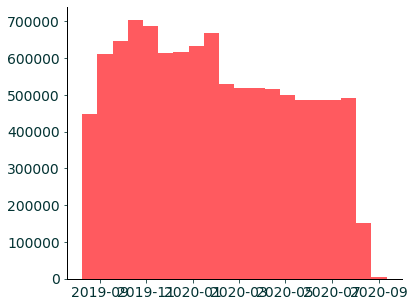

In [20]:
b_calendar.loc[b_calendar["available"] == "t", :].date.hist(bins=20)

<AxesSubplot:>

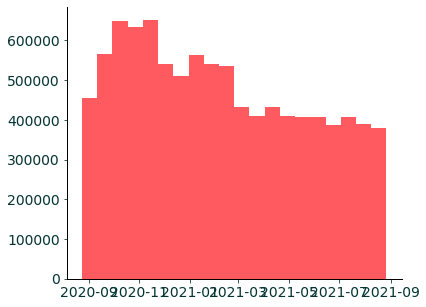

In [21]:
a_calendar.loc[a_calendar["available"] == "t", :].date.hist(bins=20)

In [22]:
a_calendar.fillna({"price": "$0"}, inplace=True)

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [23]:
a_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,currency
2,81951,2020-08-28,t,190.0,$190.00,5.0,10.0,$
3,81951,2020-08-29,t,190.0,$190.00,5.0,10.0,$
4,81951,2020-08-30,t,190.0,$190.00,5.0,10.0,$
5,81951,2020-08-31,t,190.0,$190.00,5.0,10.0,$
6,81951,2020-09-01,t,190.0,$190.00,5.0,10.0,$


In [24]:
a_calendar.price.value_counts()

50.0      327615
40.0      297645
35.0      278577
45.0      259483
30.0      252722
           ...  
1912.0         1
1242.0         1
1923.0         1
1422.0         1
2039.0         1
Name: price, Length: 1941, dtype: int64

In [25]:
a_calendar.fillna({"price": "$0"}, inplace=True)

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [26]:
a_calendar["price"].astype("str")

2           190.0
3           190.0
4           190.0
5           190.0
6           190.0
            ...  
27078339    165.0
27078340    165.0
27078341    165.0
27078342    165.0
27078343    165.0
Name: price, Length: 9703600, dtype: object

In [27]:
a_calendar["currency"] = a_calendar["price"].astype("str").str[0]

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

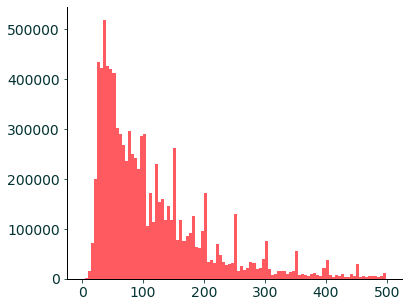

In [30]:
a_calendar.loc[a_calendar["price"] < 500, :].price.hist(bins=100)

<AxesSubplot:>

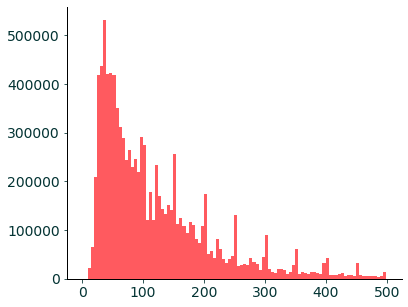

In [31]:
b_calendar.loc[b_calendar["price"] < 500, :].price.hist(bins=100)

In [32]:
a_calendar.loc[a_calendar["price"] == 0, :].head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,currency
12564952,23927173,2020-08-27,t,0.0,NaN,1.0,1125.0,0
12564953,23927173,2020-08-28,t,0.0,NaN,1.0,1125.0,0
12564955,23927173,2020-08-30,t,0.0,NaN,1.0,1125.0,0
12564956,23927173,2020-08-31,t,0.0,NaN,1.0,1125.0,0
12564957,23927173,2020-09-01,t,0.0,NaN,1.0,1125.0,0


(0.0, 1000.0)

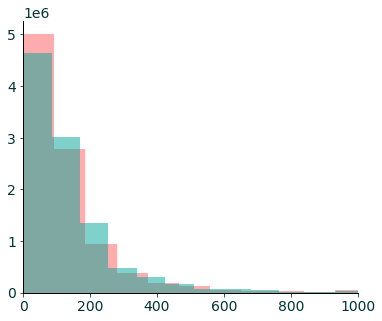

In [33]:
a_calendar["price"].hist(bins=200, alpha=0.5, label='2019')
b_calendar["price"].hist(bins=200, alpha=0.5, label='2019')
plt.xlim(0, 1000)

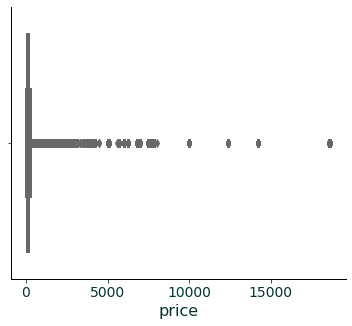

In [34]:
ax = sns.boxplot(x=a_calendar["price"])

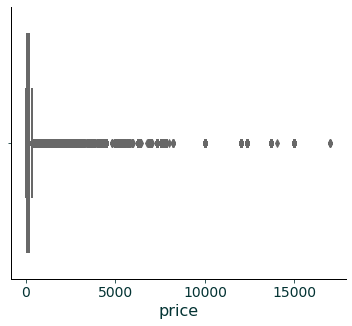

In [35]:
ax = sns.boxplot(x=b_calendar["price"])

(0.0, 1000.0)

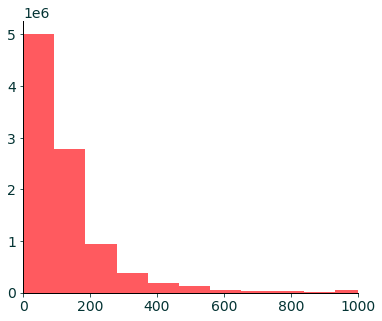

In [36]:
a_calendar["price"].hist(bins=200)
plt.xlim(0, 1000)

In [37]:
a_calendar.currency.value_counts(dropna=False)

1    2839910
2    1512443
3    1282538
4    1020311
5     835770
6     599716
7     574097
9     524811
8     513855
0        149
Name: currency, dtype: int64

In [38]:
b_calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,currency
0,13913,2019-08-10,t,50.0,$50.00,1.0,29.0,$
7,158939,2019-08-16,t,110.0,$110.00,2.0,14.0,$
8,158939,2019-08-17,t,110.0,$110.00,2.0,14.0,$


In [39]:
b_calendar.price.value_counts()

50.0      302566
40.0      275923
35.0      273282
60.0      233410
45.0      232379
           ...  
2006.0         1
2005.0         1
2004.0         1
2003.0         1
1846.0         1
Name: price, Length: 2294, dtype: int64

<AxesSubplot:>

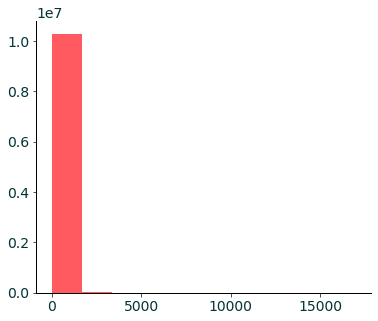

In [40]:
b_calendar.price.hist()

## Listings

In [41]:
b_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190809063821,2019-08-10,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.15
1,15400,https://www.airbnb.com/rooms/15400,20190809063821,2019-09-13,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,t,f,strict_14_with_grace_period,t,t,1,1,0,0,0.73
2,17402,https://www.airbnb.com/rooms/17402,20190809063821,2019-08-10,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,15,15,0,0,0.40
3,24328,https://www.airbnb.com/rooms/24328,20190809063821,2019-08-10,Battersea bedroom & office w parking shared ga...,"Artist house, bright high ceiling rooms, priva...",- End of terrace two bedroom house close to So...,"Artist house, bright high ceiling rooms, priva...",family,"- Battersea is a quiet family area, easy acces...",...,f,f,moderate,t,t,1,1,0,0,0.87
4,25023,https://www.airbnb.com/rooms/25023,20190809063821,2019-08-10,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",none,This is a leafy residential area with excellen...,...,f,f,moderate,f,f,1,1,0,0,0.74


## Reviews

In [42]:
a_reviews.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,11551,41044,2010-05-09,104133,Chase,Adriano was a fantastic host. We felt very at ...
3,11551,48926,2010-06-01,122714,John & Sylvia,We had a most wonderful stay with Adriano and ...
4,11551,58352,2010-06-28,111543,Monique,I'm not sure which of us misunderstood the s...


In [43]:
new_reviews = a_reviews.loc[((a_reviews["date"] > "2020-03-01") & (a_reviews["date"] < "2020-07-01")), :]

Text(0.5, 1.0, 'Histogram of Reviews 2020')

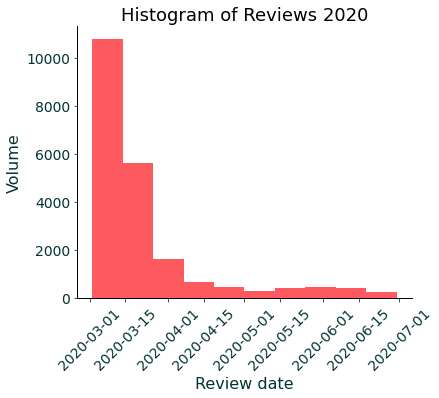

In [44]:
new_reviews.date.hist()
plt.xticks(rotation=45)
plt.xlabel("Review date")
plt.ylabel("Volume")
plt.title("Histogram of Reviews 2020")

Text(0.5, 1.0, 'Histogram of Reviews 2020')

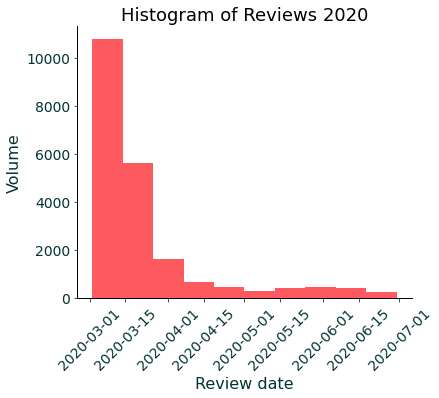

In [45]:
new_reviews.date.hist()
plt.xticks(rotation=45)
plt.xlabel("Review date")
plt.ylabel("Volume")
plt.title("Histogram of Reviews 2020")

In [46]:
old_reviews = b_reviews.loc[((b_reviews["date"] > "2019-03-01") & (b_reviews["date"] < "2019-07-01")), :]

Text(0.5, 1.0, 'Histogram of Reviews 2019')

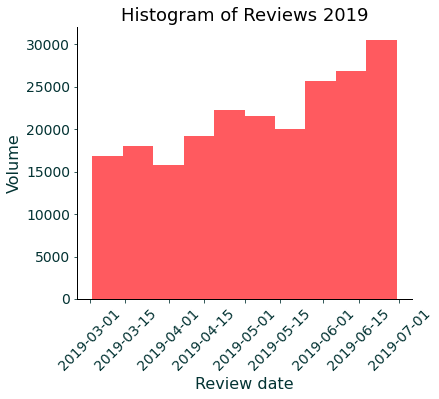

In [47]:
old_reviews.date.hist()
plt.xticks(rotation=45)
plt.xlabel("Review date")
plt.ylabel("Volume")
plt.title("Histogram of Reviews 2019")

Let's overlay the data from each year

In [48]:
old_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
14,13913,451955791,2019-05-12,58728173,Charles,"Alina's place is cosy, convenient, and full of..."
15,13913,467269212,2019-06-10,2291517,Henry,"Alina, was very quick to respond. Thoughtful a..."
97,15400,434646586,2019-04-08,242469216,Lynn,"Location, location, location!!! Philippa is ..."
98,15400,438249851,2019-04-16,89780620,栗子Elly,"Philippa的房子在住宅区内,环境很好,非常的安静,房间内设施很齐全(吹风机,洗衣机,烘..."
99,15400,441942910,2019-04-22,138449721,Sarah,We had a lovely and comfortable stay in Philip...
...,...,...,...,...,...,...
1401438,36144688,478758214,2019-06-30,142512743,Mackinzee,It was nice and well kept. Location was great....
1401538,36167210,477857358,2019-06-29,129218410,Johannes,The host canceled this reservation 6 days befo...
1401543,36167969,478747690,2019-06-30,238499585,Aidan,"Hospitality was great, was a very nice place. ..."
1401578,36176058,478117665,2019-06-29,266322262,Ogi,The host canceled this reservation 12 days bef...


In [49]:
old_reviews['date_month'] = old_reviews['date'].dt.strftime('%d/%m')

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
new_reviews['date_month'] = new_reviews['date'].dt.strftime('%d/%m')

/backup/lab/users/laura/venv/airbnb_london_eda/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
# old_reviews['date'].dt.day

In [52]:
old_reviews.date_month

14         12/05
15         10/06
97         08/04
98         16/04
99         22/04
           ...  
1401438    30/06
1401538    29/06
1401543    30/06
1401578    29/06
1401601    30/06
Name: date_month, Length: 216765, dtype: object

In [53]:
# new_reviews.date

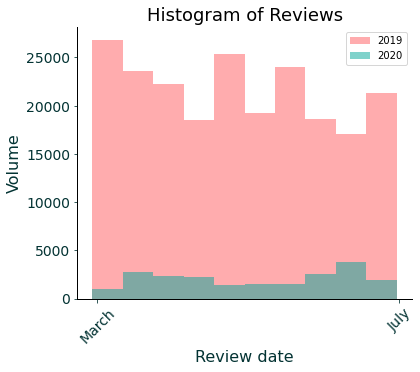

In [54]:
x = old_reviews.date_month
y = new_reviews.date_month

bins=10

plt.hist(x, bins=bins, alpha=0.5, label='2019')
plt.hist(y, bins=bins, alpha=0.5, label='2020')

plt.legend(loc='upper right')
plt.xticks(ticks=["08/04", "1"], labels=["March", "July"], rotation=45)
plt.xlabel("Review date")
plt.ylabel("Volume")
plt.title("Histogram of Reviews")

plt.show()

In [55]:
x.max()

'31/05'

In [56]:
y.max()

'31/05'

In [57]:
x.min()

'01/04'

In [58]:
text = " ".join(str(comment) for comment in old_reviews.comments)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 49311456 words in the combination of all review.


Maybe we will see different sentiment expressed in the review comments? i.e. more comments about cleanliness and covid related. 

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["room", "stay", "London", "place", "apartment", "great"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("2019 Reviews")
plt.show()

In [ ]:
text = " ".join(str(comment) for comment in new_reviews.comments)
print ("There are {} words in the combination of all review.".format(len(text)))

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["room", "stay", "London", "place", "apartment", "great"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("2020 Reviews")
plt.show()

Seems like the top words mentioned in the reviews are laregely the same. 

## Recent rentals

In [ ]:
recent_old_reviews = b_reviews.loc[b_reviews["date"] > "2019-07-01", :]

In [ ]:
recent_new_reviews = a_reviews.loc[a_reviews["date"] > "2019-07-01", :]

In [ ]:
recent_old_reviews['date_month'] = recent_old_reviews['date'].dt.strftime('%d/%m')
recent_new_reviews['date_month'] = recent_new_reviews['date'].dt.strftime('%d/%m')

In [ ]:
y.max()

In [ ]:
x.max()

## Evaluation

We see that the volume of stays has changed dramatically between 2019 and 2020. 

The sentiment of the reviews has generally remained the same, which we can see from the 
corresponding wordclouds from the 2019 and 2020 reviews respectively having the same top words. 
This evidence contradicts the idea that there might be more of a focus on reporting the 
cleanliness of airbnb properties. 
 
 The volume of propoerties available was slightly higher in 2019 vs 2020, but not 
 dramatically different.
 